# Worksheet 7 - Classification (Part II)

### Lecture and Tutorial Learning Goals:

After completing this week's lecture and tutorial work, you will be able to:

* Describe what a test data set is and how it is used in classification.
* Using R, evaluate classification accuracy using a test data set and appropriate metrics.
* Using R, execute cross-validation in R to choose the number of neighbours.
* Identify when it is necessary to scale variables before classification and do this using R
* In a dataset with > 2 attributes, perform k-nearest neighbour classification in R using the `tidymodels` package to predict the class of a test dataset.
* Describe advantages and disadvantages of the k-nearest neighbour classification algorithm.

This worksheet covers parts of [Chapter 7](https://ubc-dsci.github.io/introduction-to-datascience/classification-continued.html) of the online textbook. You should read this chapter before attempting the worksheet.

In [1]:
### Run this cell before continuing.
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)
source('tests.R')
source('cleanup.R')

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

**Question 0.1** Multiple Choice:
<br>{points: 1}

Before applying k-nearest neighbour to a classification task, we need to scale the data. What is the purpose of this step?

A. To help speed up the knn algorithm.

B. To convert all data observations to numeric values.

C. To ensure all data observations will be on a comparable scale and contribute equal shares to the calculation of the distance between points.

D. None of the above.

*Assign your answer to an object called `answer0.1`. Make sure your answer is an uppercase letter and is surrounded by quotation marks (e.g. `"F"`)*.

In [2]:
answer0.1 <- "C"

In [3]:
test_0.1()

[1] "Success!"


## 1. Fruit Data Example - (Part II)
**Question 1.0** 
<br>{points: 1}

First, load the file, `fruit_data.csv` (found in the data folder) from the previous tutorial, into your notebook.

`mutate()` the `fruit_name` column such that it is a factor using `as_factor()`.

*Assign your data to an object called `fruit_data`.*

In [4]:
fruit_data <- read_csv("data/fruit_data.csv") %>% mutate(fruit_name = as_factor(fruit_name))


Parsed with column specification:
cols(
  fruit_label = col_double(),
  fruit_name = col_character(),
  fruit_subtype = col_character(),
  mass = col_double(),
  width = col_double(),
  height = col_double(),
  color_score = col_double()
)



In [5]:
test_1.0()

[1] "Success!"


Let's take a look at the first six observations in the fruit dataset. Run the cell below.

In [6]:
# Run this cell. 
slice(fruit_data, 1:6)

fruit_label,fruit_name,fruit_subtype,mass,width,height,color_score
<dbl>,<fct>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,apple,granny_smith,192,8.4,7.3,0.55
1,apple,granny_smith,180,8.0,6.8,0.59
1,apple,granny_smith,176,7.4,7.2,0.60
2,mandarin,mandarin,86,6.2,4.7,0.80
2,mandarin,mandarin,84,6.0,4.6,0.79
2,mandarin,mandarin,80,5.8,4.3,0.77


Run the cell below, and find the nearest neighbour based on mass and width to the first observation just by looking at the scatterplot (the first observation has been circled for you).

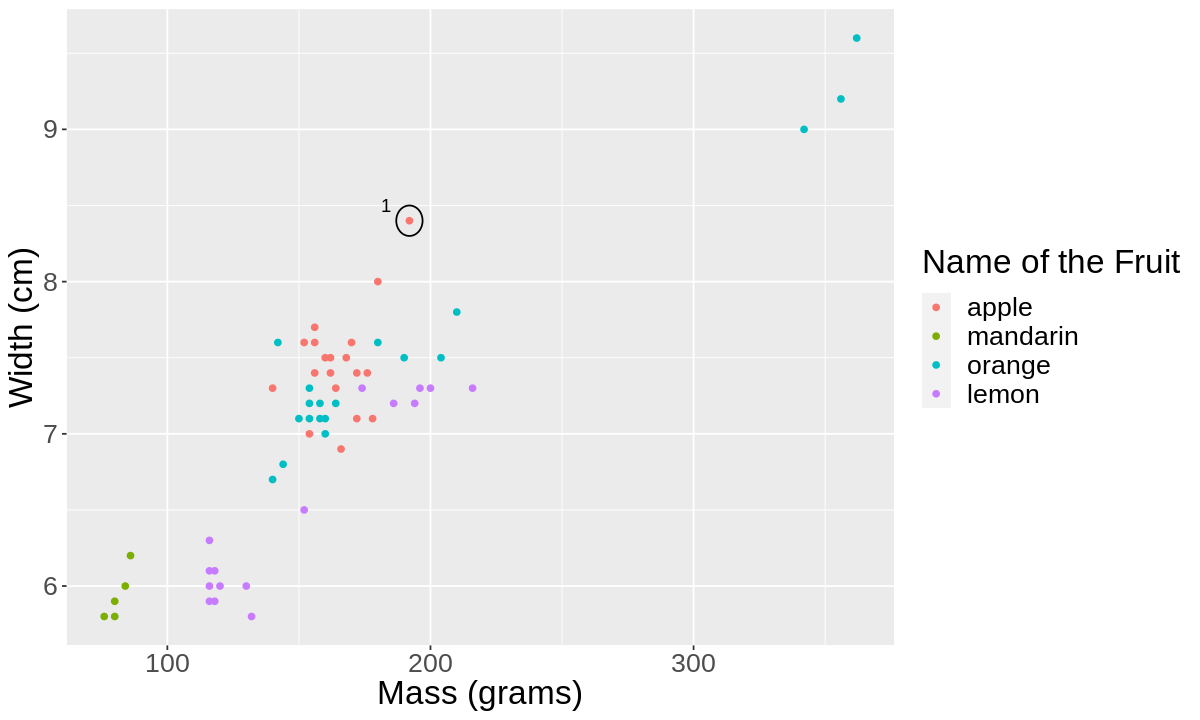

In [7]:
# Run this cell. 
options(repr.plot.width=10, repr.plot.height=6)
point1 <- c(192, 8.4)
point2 <- c(180, 8)
point44 <- c(194, 7.2)

fruit_data %>%  
    ggplot(aes(x=mass, 
               y= width, 
               colour = fruit_name)) +
        labs(x = "Mass (grams)",
             y = "Width (cm)",
            colour = 'Name of the Fruit') +
        geom_point() +
        annotate("path", 
                 x=point1[1] + 5*cos(seq(0,2*pi,length.out=100)),
                 y=point1[2] + 0.1*sin(seq(0,2*pi,length.out=100))) +
        annotate("text", x = 183, y =  8.5, label = "1") +
        theme(text = element_text(size = 20))

**Question 1.1** Multiple Choice:
<br>{points: 1}

Based on the graph generated, what is the `fruit_name` of the closest data point to the one circled?

A. apple

B. lemon

C. mandarin

D. orange

*Assign your answer to an object called `answer1.1`. Make sure your answer is an uppercase letter and is surrounded by quotation marks (e.g. `"F"`).*

In [8]:
answer1.1 <- "A"

In [9]:
test_1.1()

[1] "Success!"


**Question 1.2**
<br>{points: 1}

Using `mass` and `width`, calculate the distance between the first observation and the second observation.

We provide a scaffolding to get you started.

*Assign your answer to an object called `fruit_dist_2`.*

In [10]:
# ... <- fruit_data %>%
#    slice(1, 2) %>% # We use slice to get the first two rows of the fruit dataset
#    select(mass, ...) %>%
#    dist()

fruit_dist_2 <- fruit_data %>%
    slice(1, 2) %>% 
    select(mass, width) %>%
    dist()
fruit_dist_2

         1
2 12.00666

In [11]:
test_1.2()

[1] "Success!"


**Question 1.3**
<br>{points: 1}

Calculate the distance between the first and the **44th observation** in the `fruit` dataset using the `mass` and `width` variables.

You can see from the data frame output from the cell below that **observation 44** has `mass` = 194 g and `width` = 7.2 cm.

*Assign your answer to an object called `fruit_dist_44`.*

fruit_label,fruit_name,fruit_subtype,mass,width,height,color_score
<dbl>,<fct>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
4,lemon,spanish_belsan,194,7.2,10.3,0.7


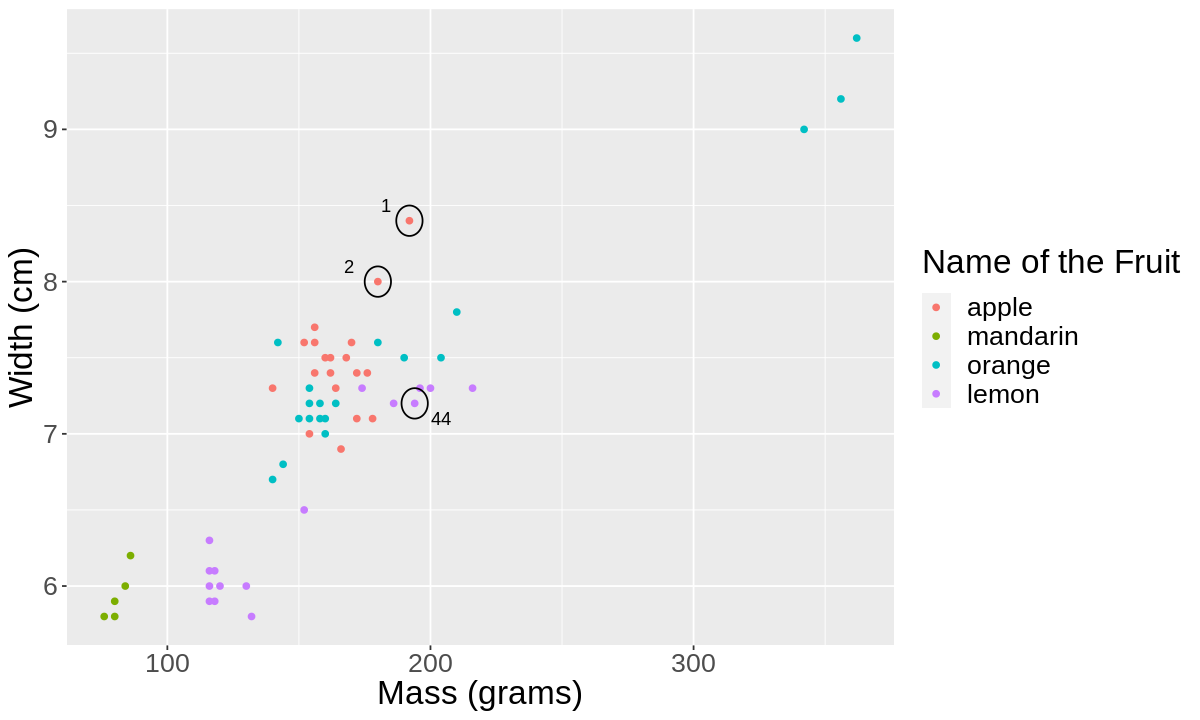

In [12]:
# Run this cell. 

filter(fruit_data, row_number() == 44)

point1 <- c(192, 8.4)
point2 <- c(180, 8)
point44 <- c(194, 7.2)

fruit_data %>%
    ggplot(aes(x = mass, 
               y = width, 
               colour = fruit_name)) +
        labs(x = "Mass (grams)",
             y = "Width (cm)",
            colour = 'Name of the Fruit') +
        geom_point() +
        annotate("path", 
                 x=point1[1] + 5*cos(seq(0,2*pi,length.out=100)),
                 y=point1[2] + 0.1*sin(seq(0,2*pi,length.out=100))) +
        annotate("text", x = 183, y =  8.5, label = "1") +
        annotate("path",
                 x=point2[1] + 5*cos(seq(0,2*pi,length.out=100)),
                 y=point2[2] + 0.1*sin(seq(0,2*pi,length.out=100))) +
        annotate("text", x = 169, y =  8.1, label = "2") +
        annotate("path",
                 x=point44[1] + 5*cos(seq(0,2*pi,length.out=100)),
                 y=point44[2]+0.1*sin(seq(0,2*pi,length.out=100))) +
        annotate("text", x = 204, y =  7.1, label = "44") +
        theme(text = element_text(size = 20))

In [13]:
fruit_dist_44 <- fruit_data %>% slice(1, 44) %>% select(mass, width) %>% dist()
fruit_dist_44

         1
2 2.332381

In [14]:
test_1.3()

[1] "Success!"


What do you notice about your answers from **Question 1.2** & **1.3** that you just calculated? Is it what you would expect given the scatter plot above? Why or why not? Discuss about this.

*Hint: Look at where the observations are on the scatterplot in the cell above this question, and what might happen if we changed grams into kilograms to measure the mass?*

**Question 1.4**
<br>{points: 1}

From the distance calculation, we see that observation 1 and 44 have a smaller distance than observation 1 and 2. However, if we look at the scatterplot the distance of the first observation to the second observation appears closer than to the 44th observation.

Which of the following statements is correct?

A. A difference of 12 g in mass between observation 1 and 2 is large compared to a difference of 1.2 cm in width between observation 1 and 44. Consequently, mass will drive the classification results, and width will have less of an effect. Hence, our distance calculation reflects that.

B. If we measured mass in kilograms, then we’d get different classification results.

C. We should standardize the data so that all variables will be on a comparable scale.

D. All of the above.

*Assign your answer to an object called `answer1.4`. Make sure your answer is an uppercase letter and is surrounded by quotation marks (e.g. `"F"`).*

In [15]:
# your code here
answer1.4 <- "D"

In [16]:
test_1.4()

[1] "Success!"


**Question 1.5**
<br>{points: 1}

Scale and center all the variables of the `fruit` dataset and save them as columns in your data table.

Save the dataset object and call it `fruit_data_scaled`. Make sure to name the new columns `scaled_*` where * is the old column name (e.g. `scaled_mass`). Do not drop the unscaled columns (`mass`, `width`, `height`, `color_score`).

In [17]:
# .. <- fruit_data %>% 
# mutate(scaled_mass = scale(mass, center = TRUE), 
#        scaled_width = scale(..., ...),
#        scaled_height = scale(..., ...),
#        scaled_color_score = scale(..., ...))

fruit_data_scaled <- fruit_data %>% mutate(scaled_mass = scale(mass, center = TRUE),
                                           scaled_width = scale(width, center = TRUE),
                                           scaled_height = scale(height, center = TRUE),
                                           scaled_color_score = scale(color_score, center = TRUE))

fruit_data_scaled

fruit_label,fruit_name,fruit_subtype,mass,width,height,color_score,scaled_mass,scaled_width,scaled_height,scaled_color_score
<dbl>,<fct>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,"<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>"
1,apple,granny_smith,192,8.4,7.3,0.55,0.5249358,1.5850841,-0.2889166,-2.769820
1,apple,granny_smith,180,8.0,6.8,0.59,0.3068287,1.0954508,-0.6562889,-2.249376
1,apple,granny_smith,176,7.4,7.2,0.60,0.2341263,0.3610008,-0.3623910,-2.119265
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
4,lemon,unknown,116,5.9,8.1,0.73,-0.8564094,-1.4751241,0.2988792,-0.4278225
4,lemon,unknown,152,6.5,8.5,0.72,-0.2020880,-0.7406741,0.5927771,-0.5579334
4,lemon,unknown,118,6.1,8.1,0.70,-0.8200582,-1.2303074,0.2988792,-0.8181553


In [18]:
test_1.5()

[1] "Success!"



**Question 1.6**
<br>{points: 1}

Let's repeat **Question 1.2** and **1.3** with the scaled variables:

- calculate the distance with the scaled mass and width variables between observations 1 and 2
- calculate the distances with the scaled mass and width variables between observations 1 and 44

After you do this, think about how these distances compared to the distances you computed in **Question 1.2** and **1.3** for the same points.

*Assign your answers to objects called `distance_2` and `distance_44` respectively.*

In [19]:
distance_2 <- fruit_data_scaled %>% slice(1, 2) %>% select(scaled_mass, scaled_width) %>% dist()
distance_2
distance_44 <- fruit_data_scaled %>% slice(1, 44) %>% select(scaled_mass, scaled_width) %>% dist()
distance_44

          1
2 0.5360145

        1
2 1.46935

In [20]:
test_1.6()

[1] "Success!"


## Randomness and Setting Seeds

This worksheet uses functions from the `tidymodels` library, which not only allows us to perform K-nearest neighbour classification, but also allows us to evaluate how well our classification worked. In order to ensure that the steps in the worksheet are reproducible, we need to set a *seed*, i.e., a numerical "starting value," which determines the sequence of random numbers R will generate.

Below in many cells we have included a call to `set.seed`. **Do not remove these lines of code**; they are necessary to make sure the autotesting code functions properly.

> *The reason we have `set.seed` in so many places is that Jupyter notebooks are organized into cells that can be run out of order. Since things can be run out of order, the exact sequence of random values that is used in each cell is hard to determine, which makes autotesting really difficult.  We had two options: either enforce that you only ever run the code by hitting "Restart & Run All" to ensure that we get the same values of randomness each time, or put `set.seed` in a lot of places (we chose the latter). One drawback of calling `set.seed` everywhere is that the numbers that will be generated won't really be random. For the purposes of teaching and learning, that is fine here. But __in your course project and other data analyses outside of this course, you must call `set.seed` only once at the beginning of the analysis, so that your random numbers are actually reasonably random.__*

## 2. Splitting the data into a training and test set

In this exercise, we will be partitioning `fruit_data` into a training (75%) and testing (25%) set using the `tidymodels` package. After creating the test set, we will put the test set away in a lock box and not touch it again until we have found the best k-nn classifier we can make using the training set. We will use the variable `fruit_name` as our class label. 


**Question 2.0**
<br> {points: 1}

To create the training and test set, first use the `initial_split` function to split `fruit_data`. Specify you want to use *75%* of the data. For the `strata` argument, place the variable we want to classify, `fruit_name`. Name the object you create `fruit_split`. 

Next, pass the `fruit_split` object to the `training` and `testing` functions and name your respective objects as `fruit_train` and `fruit_test`. 

In [21]:
# Set the seed. Don't remove this!
set.seed(3456) 

# Randomly take 75% of the data in the training set. 
# This will be proportional to the different number of fruit names in the dataset.

#... <- initial_split(..., prop = ..., strata = ...)  
#... <- training(...)   
#... <- testing(...)

fruit_split <- initial_split(fruit_data, prop = 0.75, strata = fruit_name)  
fruit_train <- training(fruit_split)   
fruit_test <- testing(fruit_split)

fruit_train
fruit_test

fruit_label,fruit_name,fruit_subtype,mass,width,height,color_score
<dbl>,<fct>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,apple,granny_smith,192,8.4,7.3,0.55
1,apple,granny_smith,180,8.0,6.8,0.59
2,mandarin,mandarin,86,6.2,4.7,0.80
⋮,⋮,⋮,⋮,⋮,⋮,⋮
4,lemon,unknown,116,6.1,8.5,0.71
4,lemon,unknown,116,6.3,7.7,0.72
4,lemon,unknown,118,6.1,8.1,0.70


fruit_label,fruit_name,fruit_subtype,mass,width,height,color_score
<dbl>,<fct>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,apple,granny_smith,176,7.4,7.2,0.60
2,mandarin,mandarin,80,5.8,4.3,0.77
1,apple,braeburn,172,7.4,7.0,0.89
⋮,⋮,⋮,⋮,⋮,⋮,⋮
4,lemon,spanish_belsan,200,7.3,10.5,0.72
4,lemon,unknown,116,5.9,8.1,0.73
4,lemon,unknown,152,6.5,8.5,0.72


In [22]:
test_2.0()

[1] "Success!"


**Question 2.1** 
<br> {points: 1}

K-nearest neighbors is sensitive to the scale of the predictors so we should do some preprocessing to standardize them. Remember that standardizing involves centering/shifting (subtracting the mean of each variable) and scaling (dividing by its standard deviation). Also remember that standardization is *part of your training procedure*, so you can't use your test data to compute the shift / scale values for each variable. Therefore, you must pass only the training data to your recipe to compute the preprocessing steps. This ensures that our test data does not influence any aspect of our model training. Once we have created the standardization preprocessor, we can then later on apply it separately to both the training and test data sets.

For this exercise, let's see if `mass` and `color_score` can predict `fruit_name`. 

To scale and center the data, first, pass the vector and the predictors to the `recipe` function. Remember to place your vector *before* your predictors. To scale your predictors, use the `step_scale(all_predictors())` function. To center your predictors, use the `step_center(all_predictors())` function.  

*Assign your answer to an object called `fruit_recipe`.*

In [23]:
set.seed(2020) # DO NOT REMOVE

#... <- recipe(... ~ ... + ... , data = ...) %>%
#    ... %>%
#    ...

fruit_recipe <- recipe(fruit_name ~ mass + color_score , data = fruit_train) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors())

fruit_recipe

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor          2

Operations:

Scaling for all_predictors()
Centering for all_predictors()

In [24]:
test_2.1()

[1] "Success!"


**Question 2.2**
<br> {points: 1}

So far, we have split the training and testing datasets as well as preprocessed the data. Now, let's create our K-nearest neighbour classifier with only the training set using the `tidymodels` package. First, create the classifier by specifying that we want $K = 3$ neighbors and that we want to use the *straight-line* distance. 

*Assign your answer to an object called `knn_spec`*.  

Next, train the classifier with the training data set using the `workflow` function. This function allows you to bundle together your pre-processing, modeling, and post-processing requests. Scaffolding is provided below for you.

*Assign your answer to an object called `fruit_fit`*.

In [25]:
set.seed(2020) # DO NOT REMOVE

#... <- nearest_neighbor(weight_func = ..., neighbors = ...) %>%
#       set_engine(...) %>%
#       set_mode(...)

#... <- workflow() %>%
#       add_recipe(...) %>%
#       add_model(...) %>%
#       fit(data = ...)

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 3) %>%
       set_engine("kknn") %>%
       set_mode("classification")

fruit_fit <- workflow() %>%
       add_recipe(fruit_recipe) %>%
       add_model(knn_spec) %>%
       fit(data = fruit_train)

fruit_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

● step_scale()
● step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = ~3, kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.06521739
Best kernel: rectangular
Best k: 3

In [26]:
test_2.2()

[1] "Success!"


**Question 2.3**
<br> {points: 1}

Now that we have created our K-nearest neighbor classifier object, let's predict the class labels for our test set.

First, pass your fitted model and the **test dataset** to the `predict` function. Then, use the `bind_cols` function to add the column of predictions to the original test data. 

*Assign your answer to an object called `fruit_test_predictions`.*

In [27]:
set.seed(2020) # DO NOT REMOVE

#... <- predict(... , ...) %>%
#       ...(...)

fruit_test_predictions <- predict(fruit_fit, fruit_test) %>%
       bind_cols(fruit_test)

fruit_test_predictions

.pred_class,fruit_label,fruit_name,fruit_subtype,mass,width,height,color_score
<fct>,<dbl>,<fct>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
apple,1,apple,granny_smith,176,7.4,7.2,0.60
mandarin,2,mandarin,mandarin,80,5.8,4.3,0.77
apple,1,apple,braeburn,172,7.4,7.0,0.89
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
lemon,4,lemon,spanish_belsan,200,7.3,10.5,0.72
lemon,4,lemon,unknown,116,5.9,8.1,0.73
orange,4,lemon,unknown,152,6.5,8.5,0.72


In [28]:
test_2.3()

[1] "Success!"


**Question 2.4**
<br> {points: 1}

Great! We have now computed some predictions for our test datasets! Wouldn't it be interesting if we could find out our classifier's accuracy? 

Thankfully, the `metrics` function from the `tidymodels` package can help us. To get the statistics about the quality of our model, you need to specify the `truth` and `estimate` arguments. In the `truth` argument, you should put the column name for the true values of the response variable. In the `estimate` argument, you should put the column name for response variable predictions. 

*Assign your answer to an object called `fruit_prediction_accuracy`.*

In [29]:
set.seed(2020) # DO NOT REMOVE

#... <- fruit_test_predictions %>%
#         ...(truth = ..., estimate = ...)             

fruit_prediction_accuracy <- fruit_test_predictions %>%
         metrics(truth = fruit_name, estimate = .pred_class)             

fruit_prediction_accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.7692308
kap,multiclass,0.6750000


In [30]:
test_2.4()

[1] "Success!"


**Question 2.5**
<br> {points: 1}

Now, let's look at the *confusion matrix* for the classifier. This will show us the table of predicted labels and correct labels. 

A confusion matrix is essentially a classification matrix. The columns of the confusion matrix represent the actual class and the rows represent the predicted class (or vice versa). Shown below is an example of a confusion matrix.

|                  |          |  Actual Values |                |
|:----------------:|----------|:--------------:|:--------------:|
|                  |          |    Positive    |    Negative    |
|**Predicted Value**  | Positive |  True Positive | False Positive|
|                  | Negative | False Negative | True Negative  |


- A **true positive** is an outcome where the model correctly predicts the positive class.
- A **true negative** is an outcome where the model correctly predicts the negative class.
- A **false positive** is an outcome where the model incorrectly predicts the positive class.
- A **false negative** is an outcome where the model incorrectly predicts the negative class.

<br>

We can create a confusion matrix by using the `conf_mat` function. Similar to the `metrics` function, you will have to specify the `truth` and `estimate` arguments. 

*Assign your answer to an object called `fruit_mat`*.

In [31]:
set.seed(2020) # DO NOT REMOVE

#... <- fruit_test_predictions %>% 
#       ...(truth = ..., estimate = ...)

fruit_mat <- fruit_test_predictions %>% conf_mat(truth = fruit_name, estimate = .pred_class)

fruit_mat

          Truth
Prediction apple mandarin orange lemon
  apple        4        0      0     0
  mandarin     0        1      0     0
  orange       0        0      3     1
  lemon        1        0      1     2

In [32]:
test_2.5()

[1] "Success!"


**Question 2.6** Multiple Choice:
<br> {points: 1}

Reading `fruit_mat`, how many observations were labelled correctly?

A. 7

B. 8

C. 9

D. 10

*Assign your answer to an object called `answer2.6`. Make sure your answer is an uppercase letter and is surrounded by quotation marks (e.g. `"F"`).*

In [33]:
answer2.6 <- "D"

In [34]:
test_2.6()

[1] "Success!"


### 3. Cross-validation

**Question 3.1**
<br> {points: 1}

The vast majority of predictive models in statistics and machine learning have parameters that you have to pick. For the past few exercises, we have had to pick the number of neighbours for the class vote. But, is it possible to make this selection, *i.e., tune the model, in a principled way?* Ideally, we want to maximize the performance of our classifier on data *it hasn’t seen yet*.

There is also an important detail to mention about the process of tuning: we can, if we want to, split our overall training data up in multiple different ways, train and evaluate a classifier for each split, and then choose the parameter based on all of the different results. If we just split our overall training data once, our best parameter choice will depend strongly on whatever data was lucky enough to end up in the validation set. Perhaps using multiple different train / validation splits, we’ll get a better estimate of accuracy, which will lead to a better choice of the number of neighbours $K$ for the overall set of training data. 

This leads to the idea of cross-validation. In cross-validation, we split our overall training data into $C$ evenly-sized chunks, and then iteratively use 1 chunk as the validation set and combine the remaining $C−1$ chunks as the **training set.**

We can perform a cross-validation in R using the `vfold_cv` function. To use this function, you have to identify the training set as well as specify the `v` (the number of folds) and the `strata` argument (the label variable). 

For this exercise, perform **$5$-fold cross-validation**.

*Assign your answer to an object called `fruit_vfold`*.

In [35]:
set.seed(2020) # DO NOT REMOVE

#... <- vfold_cv(..., v = ..., strata = ...)

fruit_vfold <- vfold_cv(fruit_train, v = 5, strata = fruit_name)

In [36]:
test_3.1()

[1] "Success!"


**Question 3.2**
<br> {points: 1}

Now perform the workflow analysis again. You can reuse the `fruit_recipe` and `knn_spec` objects you made earlier. When you are fitting the knn model, use the `fit_resamples` function instead of the `fit` function for training. This function will allow us to run a cross-validation on each train/validation split we created in the previous question. 

*Assign your answer to an object called `fruit_resample_fit`*.

In [37]:
set.seed(2020) # DO NOT REMOVE

#... <- workflow() %>%
#       add_recipe(...) %>%
#       add_model(...) %>%
#       fit_resamples(resamples = ...)

fruit_resample_fit <- workflow() %>% add_recipe(fruit_recipe) %>% add_model(knn_spec) %>%
    fit_resamples(resamples = fruit_vfold)

! Fold2: internal: No observations were detected in `truth` for level(s): 'mandar...

! Fold4: internal: No observations were detected in `truth` for level(s): 'mandar...



In [38]:
test_3.2()

[1] "Success!"


**Question 3.3** 
<br> {points: 1}

Now that we have ran a cross-validation on each train/validation split, one has to ask, how accurate was the classifier's validation across the folds? We can aggregate the *mean* and *standard error* by using the `collect_metrics` function. The standard error is essentially a measure of how uncertain we are in the mean value. 

Use the `collect_metrics` function on the `fruit_resample_fit` object and assign your answer to an object called `fruit_metrics`.

In [39]:
fruit_metrics <- collect_metrics(fruit_resample_fit)
fruit_metrics

.metric,.estimator,mean,n,std_err
<chr>,<chr>,<dbl>,<int>,<dbl>
accuracy,multiclass,0.8828283,5,0.06643670
roc_auc,hand_till,0.9612269,5,0.02364768


In [40]:
test_3.3()

[1] "Success!"


## 4. Parameter value selection

Using a 5-fold cross-validation, we have established a prediction accuracy for our classifier. 

If we had to improve our classifier, we have to change the parameter: number of neighbours, $K$. Since cross-validation helps us evaluate the accuracy of our classifier, we can use cross-validation to calculate an accuracy for each value of $K$ in a reasonable range, and then pick the value of $K$ that gives us the best accuracy. 

The great thing about the `tidymodels` package is that it provides a very simple syntax for tuning models. Using `tune()`, each parameter in the model can be adjusted rather than given a specific value. 

**Question 4.0**
<br> {points: 1}

Create a new K-nearest neighbor model specification but instead of specifying a particular value for the `neighbors` argument, insert `tune()`. 

*Assign your answer to an object called `knn_tune`.* 

In [41]:
set.seed(2020) # DO NOT REMOVE

knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
    set_engine("kknn") %>%
    set_mode("classification")

knn_tune

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


In [42]:
test_4.0()

[1] "Success!"


**Question 4.1**
<br>{points: 1}

Now, create a `workflow()` analysis that combines `fruit_recipe` and our new `knn_tune` model specification. 

Instead of using `fit` or `fit_resamples`, we will use the `tune_grid` function to fit the model for each value in a range of parameter values. For the `resamples` argument, input the cross-validation `fruit_vfold` model we created earlier. The `grid` argument specifies that the tuning should try $X$ amount of values of the number of neighbors $K$ when tuning. For this exercise, use *10 $K$ values when tuning*. 

Finally, aggregate the mean and standard error by using the `collect_metrics` function.

*Assign your answer to an object called `knn_results`.*

In [45]:
set.seed(1234) # set the seed, don't remove this

#... <- workflow() %>%
#       add_recipe(...) %>%
#       add_model(...) %>%
#       tune_grid(resamples = ..., grid = ...) %>%
#       ...

knn_results <- workflow() %>%
       add_recipe(fruit_recipe) %>%
       add_model(knn_tune) %>%
       tune_grid(resamples = fruit_vfold, grid = 10) %>%
       collect_metrics()
       
knn_results

! Fold2: internal: No observations were detected in `truth` for level(s): 'mandar...

! Fold4: internal: No observations were detected in `truth` for level(s): 'mandar...



neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,accuracy,multiclass,0.9373737,5,0.02583174,Model01
2,roc_auc,hand_till,0.9737269,5,0.01743388,Model01
3,accuracy,multiclass,0.8828283,5,0.06643670,Model02
⋮,⋮,⋮,⋮,⋮,⋮,⋮
13,roc_auc,hand_till,0.8562500,5,0.02522086,Model09
14,accuracy,multiclass,0.4643939,5,0.05560202,Model10
14,roc_auc,hand_till,0.8369213,5,0.02825852,Model10


In [46]:
test_4.1()

[1] "Success!"


**Question 4.2**
<br>{points: 1} 


Now, let's find the best value of the number of neighbors. 

First, from `knn_results`, filter for `accuracy` from the `.metric` column. 

*Assign your answer to an object called `accuracies`.*

Next, create a line plot using the `accuracies` dataset with `neighbors` on the x-axis and the `mean` on the y-axis. 

*Assign your answer to an object called `accuracy_versus_k`.*

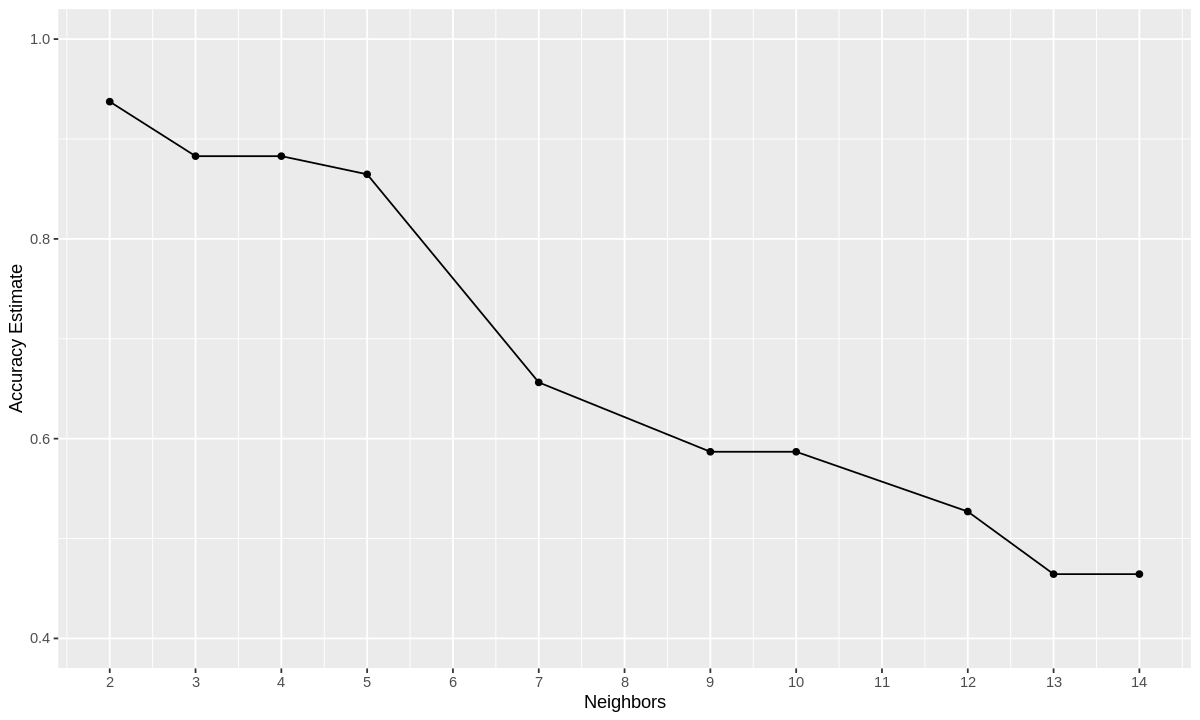

In [216]:
#... <- knn_results %>% 
#       filter(...)

#... <- ggplot(..., aes(x = ..., y = ...))+
#       geom_point() +
#       geom_line() +
#       labs(x = "Neighbors", y = "Accuracy Estimate") +
#       scale_x_continuous(breaks = seq(0, 14, by = 1)) +  # adjusting the x-axis
#       scale_y_continuous(limits = c(0.4, 1.0)) # adjusting the y-axis

accuracies <- knn_results %>% filter(.metric == "accuracy")

accuracy_versus_k <- accuracies %>% ggplot(aes(x = neighbors, y = mean)) +
    geom_point() + geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate") +
    scale_x_continuous(breaks = seq(0, 14, by = 1)) +  # adjusting the x-axis
    scale_y_continuous(limits = c(0.4, 1.0)) # adjusting the y-axis

accuracy_versus_k

In [217]:
test_4.2()

[1] "Success!"


From the plot above, we can see that $K = 2$, $3$, or $4$ provides the highest accuracy. Larger $K$ values result in a reduced accuracy estimate. Remember: the values you see on this plot are estimates of the true accuracy of our classifier. Although the $K = 2$, $3$ or $4$ value is higher than the others on this plot, that doesn’t mean the classifier is necessarily more accurate with this parameter value! 

Great, now you have completed a full workflow analysis with cross-validation using the `tidymodels` package! For your information, we can choose any number of folds and typically, the more we use the better our accuracy estimate will be (lower standard error). However, more folds would mean a greater computation time. In practice, $C$ is chosen to be either 5 or 10. 

In [218]:
source('cleanup.R')